### Обучаем первую модель на MNIST

In [1]:
import torch
from torch import Tensor, nn
from torch.utils.data import Dataset, DataLoader

#### 1. Датасет MNIST

- какие атрибуты есть у объекта `torchvision.datasets.MNIST`?
- как выглядит одно наблюдение?

In [2]:
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(
    "data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),  # что это?
)
test_dataset = datasets.MNIST(
    "data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

In [3]:
isinstance(train_dataset, Dataset)

True

In [4]:
x, y = train_dataset[0]
print(x.shape)
print(y)

torch.Size([1, 28, 28])
5


Выведем по одному примеру изображения для всех классов

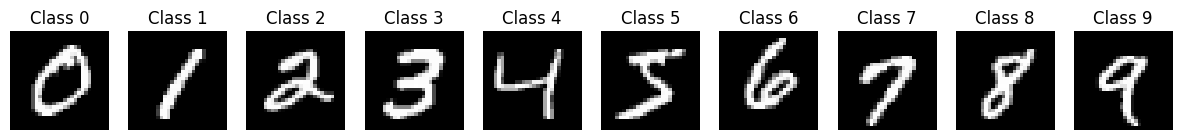

In [5]:
import matplotlib.pyplot as plt

examples = {}

for img, label in train_dataset:
    if label not in examples:
        examples[label] = img
    if len(examples) == 10: 
        break


fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].axis('off')
    axes[i].imshow(examples[i].squeeze(), cmap='gray')
    axes[i].set_title(f'Class {i}')

plt.show()

Создадим загрузчики данных и получим мини-батч:

In [6]:
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
batch: tuple[Tensor, Tensor] = next(iter(train_loader))  # что возвращает `iter()`?
x, y = batch
print(x.shape)
print(y.shape)

torch.Size([4, 1, 28, 28])
torch.Size([4])


Со свёрточными сетями мы познакомимся позже, сейчас же мы будем экспериментировать с обычными **полносвязными** сетями, но для этого нам нужно будет преобразовать форму батча из `(batch_size, channels, width, height)` в `(batch_size, channels * width * height)`:

In [8]:
batch_size, channels, width, height = x.shape
input_dim = channels * width * height
print(input_dim)

x.flatten(start_dim=1).shape

784


torch.Size([4, 784])

Ура, с данными вроде разобрались! Теперь разберёмся с моделью

#### 2. Реализуем модель с помощью `torch.nn.Module`

Для простоты будем строить небольшую нейронку из двух полносвязных слоёв и `tanh` в качестве функции активации.

$\mathbf{h} = \tanh(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1)$

$\text{logits} = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2$

Из этих выходных данных нам хотелось бы получить вероятностное распределение над возможными классами, то есть нужно как-то нормализовать эти активации, для этого обычно используется функция `softmax`:

$$
\text{softmax}(\mathbf{x})_i = \frac{e^{\mathbf{x}_i}}{\sum_j e^{\mathbf{x}_j}}
$$

In [9]:
z = torch.randn(5)  # что-то похожее будет нам возвращать модель
print(z)
print(torch.softmax(z, dim=0))  # когда нам понадобятся вероятности классов, применим softmax


tensor([-1.1247, -1.2709, -0.3789,  0.2596, -0.2793])
tensor([0.0972, 0.0839, 0.2048, 0.3878, 0.2263])


Реализуем двуслойный перцептрон как наследник `nn.Module`.

Метод `forward` будет возвращать логиты, т. е. выход последнего линейного слоя без применения функции активации `softmax`.

In [10]:
class SimpleNet(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int) -> None:
        super().__init__()
        # параметры первого слоя
        self.w1 = nn.Parameter(torch.randn(input_dim, hidden_dim))
        self.b1 = nn.Parameter(torch.randn(hidden_dim))

        # параметры второго слоя
        self.w2 = nn.Parameter(torch.randn(hidden_dim, output_dim))
        self.b2 = nn.Parameter(torch.randn(output_dim))

    def forward(self, x: Tensor) -> Tensor:
        h = x.flatten(1) @ self.w1 + self.b1  # первый слой
        h = h.tanh()  # нелинейная функция активации, можно выбрать и другую
        logits = h @ self.w2 + self.b2  # второй слой
        return logits

In [11]:
hidden_dim = 128
n_classes = 10

model = SimpleNet(input_dim, hidden_dim, n_classes)
logits = model(x)
logits.shape

torch.Size([4, 10])

Наши логиты — ненормализованные величины, сырой выход из последнего слоя модели. Чтобы интерпретировать их как вероятности классов, пропустим через `softmax`:

In [12]:
logits.softmax(dim=1).round(decimals=3)

tensor([[0.0000, 0.0000, 0.1970, 0.0000, 0.0010, 0.0000, 0.0000, 0.0000, 0.8010,
         0.0000],
        [0.0000, 0.0000, 0.4720, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5280,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.9980, 0.0000, 0.0000, 0.0000, 0.0020,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], grad_fn=<RoundBackward1>)

Обратите внимание: классы получились далеко не равновероятны, хотя мы ещё не учили модель. Подумайте, почему так произошло?
Подробнее это мы обсудим на следующей практике.

Вручную обновлять значения многих параметров очень неудобно. К счастью, за нас это сделает оптимизатор

In [13]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.05)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.05
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


Посчитаем ошибку и градиенты на одном минибатче:

In [14]:
# получим предсказания и посчитаем ошибку
predictions = model.forward(x)
loss = torch.nn.functional.cross_entropy(predictions, y)
print(loss)
# рассчитаем градиенты и обновим параметры
loss.backward()
optimizer.step()

# не забудем почистить градиенты, мы не хотим их накапливать
optimizer.zero_grad()

tensor(18.5546, grad_fn=<NllLossBackward0>)


#### 3. Обучение

##### Шаг обучения: что мы делаем с каждым минибатчем данных

In [15]:
def training_step(
    x: Tensor,
    y: Tensor,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
) -> tuple[Tensor, Tensor]:
    # прогоняем батч через модель
    predictions = model(x)
    # оцениваем значение ошибки
    loss = torch.nn.functional.cross_entropy(predictions, y)
    # обновляем параметры
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    # возвращаем значение функции ошибки для логирования
    return loss, predictions

Для тестовых батчей нам не нужны градиенты, поэтому отключим их расчёт с помощью декоратора `@torch.no_grad`

In [16]:
@torch.no_grad()
def test_step(
    x: Tensor,
    y: Tensor,
    model: torch.nn.Module,
) -> tuple[Tensor, Tensor]:
    predictions = model(x)
    # оцениваем значение ошибки
    loss = torch.nn.functional.cross_entropy(predictions, y)
    return loss, predictions

##### Что мы хотим делать в каждой эпохе?

Напишем функцию для запуска одной эпохи (обучающей или тестовой), которая
- итерируется по минибатчам
- обрабатывает их
- в конце эпохи выводит среднюю ошибку и точность классификации.

In [17]:
def run_epoch(
    is_train: bool,
    dataloader: DataLoader,
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
) -> None:
    loss_val: list[float] = [] # список ошибкок
    correct = 0
    
    for x, y in dataloader:
        if is_train:
            loss, preds = training_step(x, y, model, optimizer)
        else:
            loss, preds = test_step(x, y, model)

        loss_val.append(loss.item())

        y_hat = preds.argmax(dim=-1) # предсказанные классы        
        correct += (y == y_hat).sum().item()

    epoch_loss = torch.tensor(loss_val).mean()
    accuracy = correct / len(dataloader.dataset)

    print(f"Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

Создадим модель, оптимизатор и загрузчики данных и запустим обучение:

In [18]:
hidden_dim = 128
n_classes = 10
batch_size = 4
n_epochs = 5

model = SimpleNet(input_dim, hidden_dim, n_classes)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.05)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
for i in range(n_epochs):
    print(f"Epoch {i} train:")
    run_epoch(True, train_loader, model, optimizer)
    print(f"Epoch {i} test:")
    run_epoch(False, test_loader, model, optimizer)

Epoch 0 train:
Loss: 0.8026, Accuracy: 0.8391
Epoch 0 test:
Loss: 0.3981, Accuracy: 0.8891
Epoch 1 train:
Loss: 0.3289, Accuracy: 0.9097
Epoch 1 test:
Loss: 0.3069, Accuracy: 0.9160
Epoch 2 train:
Loss: 0.2525, Accuracy: 0.9266
Epoch 2 test:
Loss: 0.2969, Accuracy: 0.9175
Epoch 3 train:
Loss: 0.2096, Accuracy: 0.9381
Epoch 3 test:
Loss: 0.2550, Accuracy: 0.9272
Epoch 4 train:
Loss: 0.1811, Accuracy: 0.9456
Epoch 4 test:
Loss: 0.2304, Accuracy: 0.9394
